# 2. Разведочный анализ данных (EDA)

## 🚀 Цели этапа
1. Анализ распределения целевой переменной
2. Исследование категориальных признаков
3. Анализ числовых признаков  
4. Поиск корреляций и взаимосвязей
5. Формулировка выводов и гипотез

In [29]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('../data/Churn_Modelling.csv')

df.info()

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
categorical_features = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
target = 'Exited'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


## 2.1 🎯Анализ целевой переменной

Анализируем дисбаланс классов - это критично для выбора метрик и стратегии борьбы с дисбалансом.

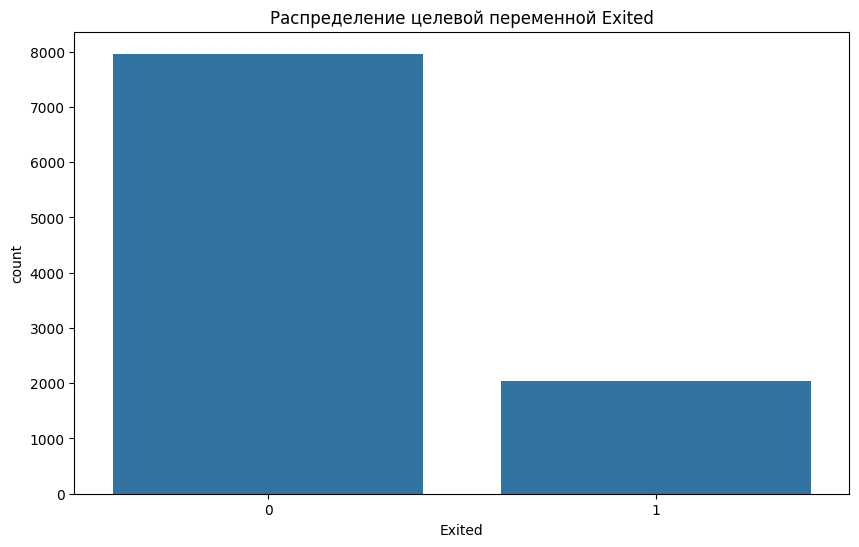

In [16]:
plt.figure(figsize=(10,6))
sb.countplot(data=df, x=target)
plt.title('Распределение целевой переменной Exited')
plt.show()

In [17]:
churn_count = df['Exited'].value_counts().min()
remaining_customers = df['Exited'].value_counts().max()
print(f"Сколько человек попали под отток: {churn_count}")
print(f"Сколько человек остались пользоваться услугами банака: {remaining_customers}")

Сколько человек попали под отток: 2038
Сколько человек остались пользоваться услугами банака: 7964


In [18]:
churn_rate = df['Exited'].value_counts(normalize=True) * 100
print(f"Процент оттока: {churn_rate[1]:.1f}%")

Процент оттока: 20.4%


Можем заметить, что у нас присутствует дисбаланс классов: из 10002 клиентов 2038 человек перестали пользоваться услугами банка, а 7964 остались преданны банку и продолжают пользоваться его услугами. Следовательно в дальнейшем этапе "Подготовка данных к обучению" мы будем использовать метода балансировки классов, чтобы наша модель давала более точные результаты

## 🔠 2.2 Исследование категориальных признаков

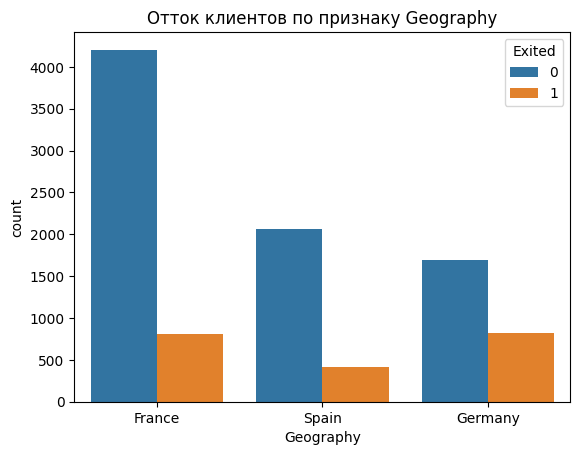

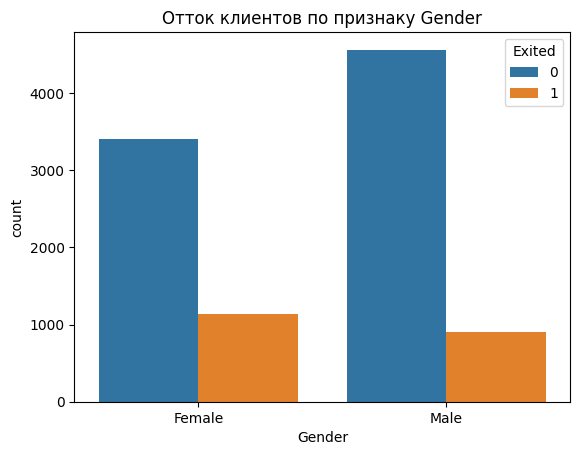

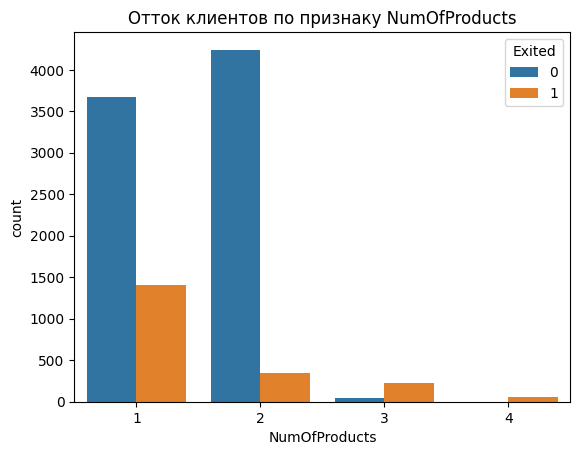

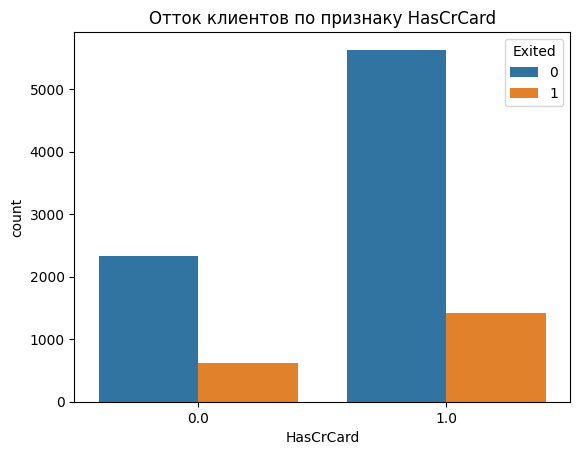

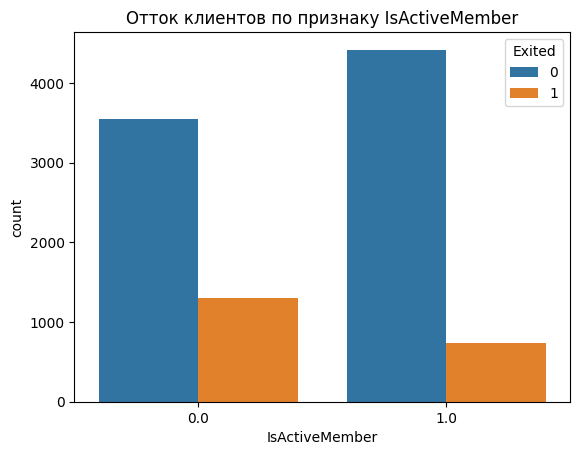

In [25]:
for column in categorical_features:
    sb.countplot(data=df, x=column, hue=target)
    plt.title(f"Отток клиентов по признаку {column}")
    plt.show()

In [39]:
for column in categorical_features:
    product_churn = df.groupby(column)['Exited'].mean() * 100
    print(product_churn)
    print('-'*50)

Geography
France     16.154767
Germany    32.470120
Spain      16.673395
Name: Exited, dtype: float64
--------------------------------------------------
Gender
Female    25.066021
Male      16.471235
Name: Exited, dtype: float64
--------------------------------------------------
NumOfProducts
1     27.708948
2      7.601830
3     82.706767
4    100.000000
Name: Exited, dtype: float64
--------------------------------------------------
HasCrCard
0.0    20.814941
1.0    20.195578
Name: Exited, dtype: float64
--------------------------------------------------
IsActiveMember
0.0    26.860441
1.0    14.271845
Name: Exited, dtype: float64
--------------------------------------------------


По представленным диаграммам, можем сделать следующие выводы:

- Больше всего клиентов уходит из Германии, причем доля ушедших в этой стране наибольшая
- Женщины склонны к оттуку больше (25%), чем мужчины (16%)
- Люди, которые имеют несколько продуктов банка (3-4) наиболее склонны к оттоку - 82% и 100% соответственно. Те кто имеет один продукт банка уходят в среднем в 27% случаев. У кого имеется два продукта банка - уходят в 7% случаев
- Показатель "Наличие кредитной карты" одинаково влияет на отток - по 20%
- Активные клиенты уходят чаще - 26% против 14%

## 🔢 2.3 Исследование числовых признаков